# In this notebook I write the routine for flight-path calibration

        What it should be done:
        - read the theoretical spectrum
        - read the calibration sample
        - be able to convert from TOF to lambda and back
        - the peak positions are detected and single edge fitting is applied
        - calculate L, T0 or deltaL, which are the results of the calibration 
        
        time to lambda convertion:
            lambda = h/mL (t-t0)
            where:lambda = wavelength [A] (A=0.1nm = 1e-10m)
                    h = Planck's constant: 6.62607004 × 10-34 m^2 kg / s
                    m = Neutron mass [kg]: 1.674 927 471 x 10-27 kg 
                    L = total flight path [m]
                    t = time of flight [s]
        
       Convertion between time of flight and neutron wavelenght can be done after flight-path calibration: the value of the distance between the source and the transmission detector L0  and the time delay of the source trigger DT0, is obtained by linear regression to the function  lambda = h/mL (t-t0), or t= lambda(mL/h)+t0, with h= Planck constant
                    
        

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
import os, fnmatch
from os import listdir
%matplotlib inline
import scipy.signal
print(scipy.__version__)
from scipy.signal import find_peaks
from scipy.signal import savgol_filter
import AdvancedBraggEdgeFitting_v2
import AdvancedBraggEdgeFitting
from TOF_routines import find_first
from TOF_routines import find_last
from scipy.stats import norm
# import seaborn as sns
# sns.set()

1.1.0


In [2]:
# Constant values
h=6.62607004e-34 #Planck constant [m^2 kg / s]
m=1.674927471e-27 #Neutron mass [kg]

#theoretical numbers from the Paper I believe
t0=0
L= 56.4 #[m]
dL = 0

In [3]:
def tof2l(tof):
    l=h/m*(tof-t0)/(L+dL)/1e-10
    return l

def l2tof(l):
    tof=t0+(l*1e-10)*(L+dL)*m/h
    return tof

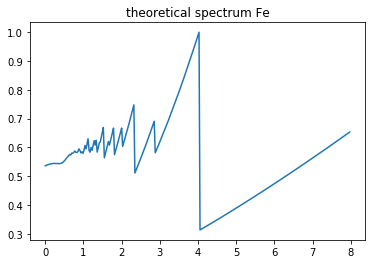

In [4]:
mylambda = np.genfromtxt('lambda.txt',usecols=0)
myspectrum = np.genfromtxt('alpha.txt',usecols=0)

# print(mylambda)
mytof = l2tof(mylambda)
relambda = tof2l(mytof)
plt.plot(mylambda, myspectrum/max(myspectrum))
plt.title('theoretical spectrum Fe')
plt.show()


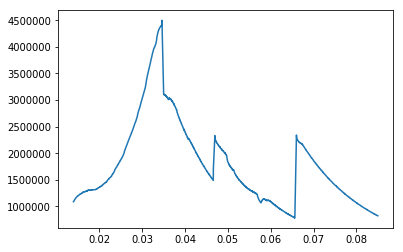

In [5]:
# Read the calibration spectrum from file
mycaltof = np.genfromtxt('/media/carminati_c/Data2/IMAT_Nov2018/02_HighStats_radio_1hruns/samples_after_reboot_OC_Fiji/IMAT00010420_HighStats_Radio_1hruns_000_Spectra.txt', usecols=0)
myhist = np.genfromtxt('/media/carminati_c/Data2/IMAT_Nov2018/02_HighStats_radio_1hruns/samples_after_reboot_OC_Fiji/IMAT00010420_HighStats_Radio_1hruns_000_Spectra.txt', usecols=1) #this is the cumulative histogram of the raw data (before the overlap correction)



plt.plot(mycaltof,myhist)
plt.show()

In [6]:
# Read the calibration datasets:
# pathdata ="/data/data2/IMAT_Nov2018/02_HighStats_radio_1hruns/samples_after_reboot_OC_Fiji/"
# pathOB = "/data/data2/IMAT_Nov2018/02_HighStats_radio_1hruns/flat_after_reboot_OC_Fiji/"

pathdata ="/media/carminati_c/Data2/IMAT_Nov2018/02_HighStats_radio_1hruns/Samples_AfterReboot_Corrected/"
pathOB = "/media/carminati_c/Data2/IMAT_Nov2018/02_HighStats_radio_1hruns/Flat_AfterReboot_Corrected/"

In [7]:
myfiles = fnmatch.filter(listdir(pathdata),'*.fits')
coll_files = sorted(myfiles)
print(coll_files[504])
print(coll_files[505])
print(coll_files[506])

obfiles = fnmatch.filter(listdir(pathOB),'*.fits') # here there are several OB folders
coll_ob = sorted(obfiles)
print(coll_ob[504])
print(coll_ob[505])
print(coll_ob[506])
# print(sorted(obfiles))

IMAT00010420_HighStats_Radio_1hruns_000_000504.fits
IMAT00010420_HighStats_Radio_1hruns_000_100000.fits
IMAT00010420_HighStats_Radio_1hruns_000_100001.fits
IMAT00010421_HighStats_Radio_1hruns_000_000504.fits
IMAT00010421_HighStats_Radio_1hruns_000_100000.fits
IMAT00010421_HighStats_Radio_1hruns_000_100001.fits


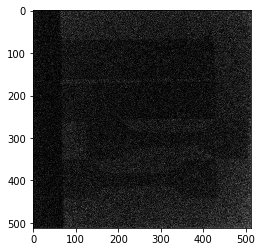

In [8]:
roi_cal = np.array([6,16,57,500])
filename = pathdata + coll_files[0]
im = fits.open(filename)
# plt.imshow(im[0].data)
plt.imshow(im[0].data[roi_cal[1]:roi_cal[3],roi_cal[0]:roi_cal[2]]) #this is the area that I want to study
plt.imshow(im[0].data, cmap='gray')

In [9]:
cal_spectrum = np.zeros(len(coll_files))
cal_ob = np.zeros(len(coll_files))
ori_hist = np.zeros(len(coll_files))
collImg= np.zeros([512,512,len(coll_files)])
collOB = np.zeros([512,512, len(coll_files)])

for i in range(0, len(coll_files)):
    
    curr_img = (fits.open(pathdata+coll_files[i])[0].data[roi_cal[1]:roi_cal[3],roi_cal[0]:roi_cal[2]]).astype(float)
    curr_ob =(fits.open(pathOB+coll_ob[i])[0].data[roi_cal[1]:roi_cal[3],roi_cal[0]:roi_cal[2]]).astype(float)
    cal_spectrum[i] = np.sum(curr_img[~np.isnan(curr_img) & ~np.isinf(curr_img)])
    cal_ob[i]= np.sum(curr_ob[~np.isnan(curr_ob) & ~np.isinf(curr_ob)])
    
    
    

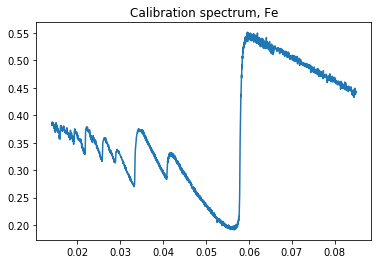

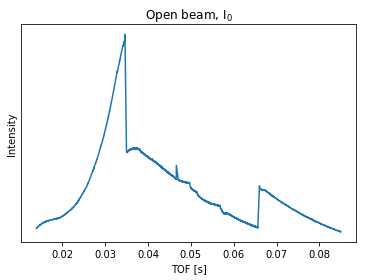

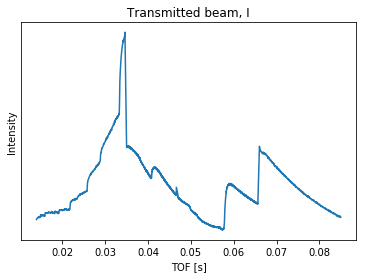

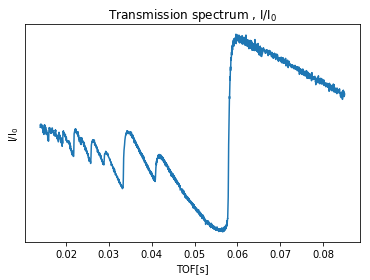

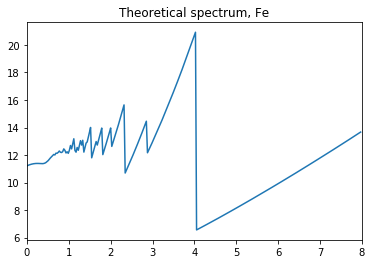

In [10]:
cal_spectrum_norm = cal_spectrum/cal_ob
mycalLambda = tof2l(mycaltof)
plt.plot(mycaltof, (cal_spectrum/cal_ob))
plt.title('Calibration spectrum, Fe')
# plt.xlim(0,8)
plt.show()

np.savetxt('spectrum_cal_transmission.txt', cal_spectrum/cal_ob)
np.savetxt('tof.txt', mycaltof)

plt.figure()
plt.plot(mycaltof, cal_ob)
plt.title('Open beam, I$_{0}$')
plt.xlabel('TOF [s]')
plt.ylabel('Intensity')
plt.yticks([])
myspectrum_norm = myspectrum/np.average(myspectrum)
plt.savefig('openbeam.pdf')

plt.figure()
plt.plot(mycaltof, cal_spectrum)
plt.title('Transmitted beam, I')
plt.xlabel('TOF [s]')
plt.ylabel('Intensity')
plt.yticks([])
myspectrum_norm = myspectrum/np.average(myspectrum)
plt.savefig('transmittedbeam.pdf')

plt.figure()
plt.plot(mycaltof, (cal_spectrum/cal_ob))
plt.title('Transmission spectrum , I/I$_{0}$')
plt.xlabel('TOF[s]')
plt.ylabel('I/I$_{0}$')
plt.yticks([])
plt.savefig('transmissionspectrum.pdf')


plt.figure()
plt.plot(mylambda, myspectrum)
plt.title('Theoretical spectrum, Fe')
plt.xlim(0,8)
plt.show()

### The two following commented cells calculate a transversal TOF image on the OB and the sample TOF, that I used for the Klausur prensentation 

In [11]:
# for i in range(0, len(coll_files)):
    
#     curr_img = (fits.open(pathdata+coll_files[i])[0].data).astype(float)
#     curr_ob =(fits.open(pathOB+coll_ob[i])[0].data).astype(float)
#     collImg[:,:,i] = curr_img
#     collOB[:,:,i] = curr_ob
#     cal_spectrum[i] = np.sum(curr_img[~np.isnan(curr_img) & ~np.isinf(curr_img)])
#     cal_ob[i]= np.sum(curr_ob[~np.isnan(curr_ob) & ~np.isinf(curr_ob)])

In [12]:
# plt.figure()
# plt.imshow(collImg[:,10,:], cmap='gray', vmin=0.0, vmax=10)
# plt.axis('off')
# plt.savefig('TOF_sample.pdf')

# plt.figure()
# plt.imshow(collOB[:,10,:], cmap='gray', vmin=0.0, vmax=30)
# plt.axis('off')
# plt.savefig('TOF_ob.pdf')

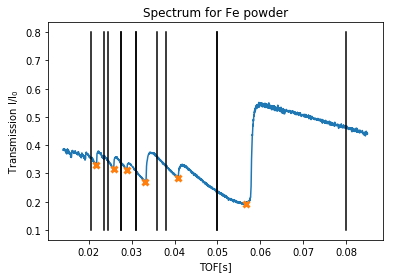

[0.0217824 0.0257555 0.0288275 0.0331693 0.0407971 0.056568 ]
[ 190  287  362  468  789 1543]


/home/carminati_c/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:2223: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
/home/carminati_c/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:2225: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
/home/carminati_c/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:2233: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this wil

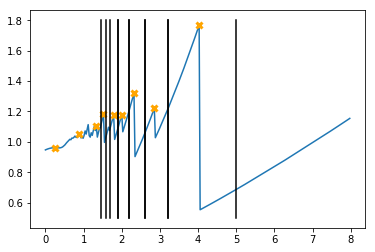

[0.24  0.88  1.333 1.52  1.787 2.    2.32  2.853 4.027]


In [13]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return (idx)

lambda_ranges=np.zeros((6,2))


lambda_ranges[5,0] = 3.2
lambda_ranges[5,1] = 5.0

lambda_ranges[4,0] = 2.6
lambda_ranges[4,1] = 3.2

lambda_ranges[3,0] = 2.2
lambda_ranges[3,1] = 2.6

lambda_ranges[2,0] = 1.9
lambda_ranges[2,1] = 2.2

lambda_ranges[1,0] = 1.7
lambda_ranges[1,1] = 1.9

lambda_ranges[0,0] = 1.45
lambda_ranges[0,1] = 1.6

tof_ranges=np.zeros((6,2))

tof_ranges[5,0] = 0.05
tof_ranges[5,1] = 0.08

tof_ranges[4,0] =  0.038
tof_ranges[4,1] =  0.05

tof_ranges[3,0] = 0.031
tof_ranges[3,1] = 0.036

tof_ranges[2,0] = 0.0275
tof_ranges[2,1] =  0.031

tof_ranges[1,0] = 0.0245
tof_ranges[1,1] =  0.0275

tof_ranges[0,0] = 0.0205
tof_ranges[0,1] =  0.0235

# yhat = savgol_filter(y, 51, 3) # window size 51, polynomial order 3
peaks, _ = find_peaks(-cal_spectrum_norm, width=15)
# peaks, _ = find_peaks(cal_spectrum_norm, width=15)
plt.plot(mycaltof, cal_spectrum_norm)
plt.plot(mycaltof[peaks],cal_spectrum_norm[peaks],'x', markeredgewidth=3)
for i in range(0,6):
    plt.plot((tof_ranges[i,0], tof_ranges[i,0]),(0.1,0.8), 'k-')
    plt.plot((tof_ranges[i,1], tof_ranges[i,1]),(0.1,0.8), 'k-')
# plt.ylim(0.8,1.02)
plt.title('Spectrum for Fe powder')
plt.xlabel('TOF[s]')
plt.ylabel('Transmission I/I$_{0}$')
plt.savefig('spectrum_ranges.pdf')
plt.show()
print(mycaltof[peaks])
print(peaks)

# print(find_nearest(mycaltof, tof_ranges[0,0]))
      

resamp_spectrum = scipy.signal.resample(myspectrum_norm, len(myspectrum_norm)*5)
# plt.plot(resamp_spectrum)
peaks_th, _ = find_peaks(myspectrum_norm, width=2)
plt.plot(mylambda, myspectrum_norm)
plt.plot(mylambda[peaks_th],myspectrum_norm[peaks_th],'x', markeredgewidth=3, c='orange')
for i in range(0,6):
    plt.plot((lambda_ranges[i,0], lambda_ranges[i,0]),(0.5,1.8), 'k-')
    plt.plot((lambda_ranges[i,1], lambda_ranges[i,1]),(0.5,1.8), 'k-')
# plt.ylim(0.3,1.02)
plt.show()

print(mylambda[peaks_th])

---- Peak positions given by the lattice parameters ----
[4.054 2.866 2.34  2.026 1.812 1.654 1.532 1.434 1.352 1.352 1.282 1.222
 1.17  1.124 1.124 1.046 1.014 0.984 0.984 0.956 0.956 0.93  0.93  0.906
 0.884 0.864 0.846 0.828 0.81  0.81  0.81  0.794 0.78  0.78  0.78  0.766
 0.752 0.728 0.728 0.716 0.706 0.706 0.706 0.696 0.696 0.686 0.676 0.676
 0.666 0.666 0.666 0.658 0.65  0.64  0.632 0.626 0.618 0.618 0.612 0.604
 0.604 0.592 0.586 0.58  0.58  0.574 0.568 0.562 0.552 0.546 0.536 0.536
 0.536 0.532 0.518 0.506 0.498 0.496 0.492 0.488 0.478 0.45  0.448 0.414]


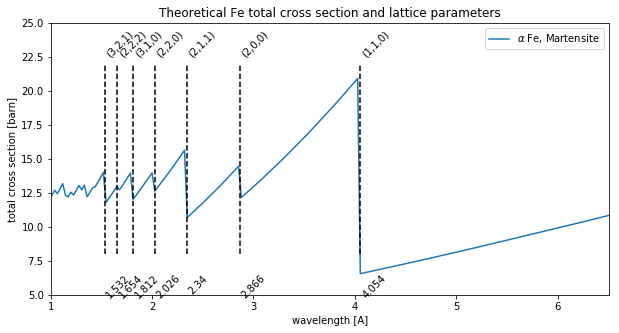

In [31]:
mylambda = np.genfromtxt('lambda.txt',usecols=0)
myalpha = np.genfromtxt('alpha.txt',usecols=0)

dhkl_alphaFe = np.genfromtxt('alphaFe_hkl', usecols=4)
h_alphaFe= np.genfromtxt('alphaFe_hkl', usecols=0)
k_alphaFe= np.genfromtxt('alphaFe_hkl', usecols=1)
l_alphaFe= np.genfromtxt('alphaFe_hkl', usecols=2)


fig, ax = plt.subplots(figsize=(10,5))
plt.plot(mylambda, myalpha, label=r'$\alpha$ Fe, Martensite')

for i in range(0,7):
    plt.plot(np.array([2*dhkl_alphaFe[i],2*dhkl_alphaFe[i]]), np.array([8,22]), '--k')
    mytext = '('+str((h_alphaFe[i]).astype(int))+','+str(k_alphaFe[i].astype(int))+','+str(l_alphaFe[i].astype(int))+')'
    plt.text(2*dhkl_alphaFe[i],24, mytext, rotation=45, color='k')
    plt.text(2*dhkl_alphaFe[i],6, str(2*dhkl_alphaFe[i]), rotation=45, color='k')

plt.legend(loc='upper right')
plt.xlim(1,6.5)
plt.ylim(5,25)
plt.ylabel('total cross section [barn]')
plt.xlabel('wavelength [A]')
plt.title('Theoretical Fe total cross section and lattice parameters')
plt.savefig("ThSpectrumFe.pdf")

print('---- Peak positions given by the lattice parameters ----')
print(dhkl_alphaFe*2)

### Here I check possible intial values of the parameters that can give me a meaninfulg initialization for the first peak 

0.0218234


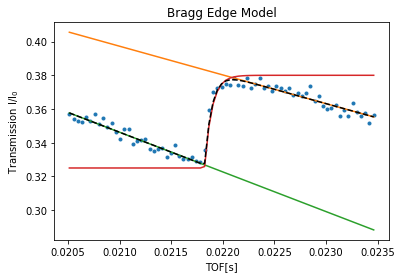

In [15]:
est_sigma = 2.0045e-06
est_alpha = 7.0005e-05
t0_pos = find_nearest(mycaltof, 0.02180949)
t0_f = mycaltof[t0_pos]
print(t0_f)
a1 = 0.75493599
a2 = -17.0328926
a5 = 0.84050937
a6 = -23.5386967

        
myrange = np.array([find_nearest(mycaltof, tof_ranges[0,0]), find_nearest(mycaltof,tof_ranges[0,1])])
t = mycaltof[myrange[0]:myrange[1]]

line_after = AdvancedBraggEdgeFitting_v2.line_after(t,a1,a2)
line_before = AdvancedBraggEdgeFitting_v2.line_before(t,a5,a6)
bragg_edge = AdvancedBraggEdgeFitting_v2.B(t,t0_f,est_alpha,est_sigma)

exp_before = AdvancedBraggEdgeFitting_v2.exp_before(t,a5,a6)
exp_after = AdvancedBraggEdgeFitting_v2.exp_after(t,a1,a2)



plt.figure()
plt.plot(t,cal_spectrum_norm[myrange[0]:myrange[1]],'.', label='experimental data')
plt.plot(t,line_after,label='linear function after the edge')
plt.plot(t, line_before, label='linear function before the edge',)
plt.plot(t,(0.38)*bragg_edge+(1-bragg_edge)*0.325, label='smooth switch function')
plt.plot(t, line_after*bragg_edge+(1-bragg_edge)*line_before ,'--',label='Bragg Edge model',color='k')
# plt.legend(loc='best')
plt.xlabel('TOF[s]')
plt.ylabel('Transmission I/I$_{0}$')
plt.title('Bragg Edge Model')

# plt.xlim([0.0205,0.08])
plt.savefig('BE_model.pdf')
# plt.plot(t,exp_after)
# plt.plot(t,exp_after*exp_before)


# plt.plot(t,exp_after*(exp_before +(1-exp_before)*bragg_edge))

# print(bragg_edge)

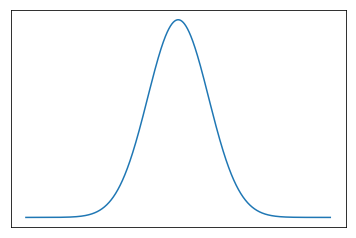

In [16]:
plt.figure()
x_axis = np.arange(-10, 10, 0.01)
plt.plot(x_axis, norm.pdf(x_axis,0,2))
# plt.axis('off')
plt.xticks([])
plt.yticks([])
plt.savefig('gaussian.pdf')

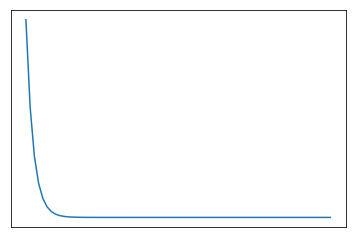

In [17]:
plt.plot(t, np.exp(-(t-t0_f)/est_alpha))
# plt.axis('off')
plt.xticks([])
plt.yticks([])
plt.savefig('exp_decay.pdf')

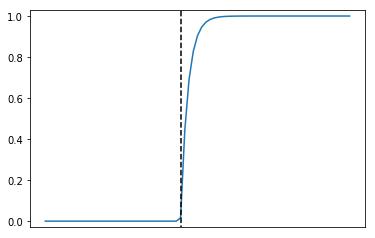

In [18]:
plt.plot(t,bragg_edge)
t0_pos = find_nearest(t, 0.02180949)
plt.plot(np.array([t0_f,t0_f]),np.array([-0.05,1.05]),'--k')
plt.ylim(-.03,1.03)
plt.xticks([])
plt.savefig("braggedge.pdf")
# t0_f = mycaltof[t0_pos]

### here I loop over all selected peaks 

[ 190  287  362  468  789 1543]
[  9  33  50  57  67  75  87 107 151]
[ 57  67  75  87 107 151]
--- RefPoints obtained from lattice parameters ---
[1.532 1.812 2.026 2.34  2.866 4.054]
number of peaks:  6
[0.0205 0.0235]
[159 232]
190
[0.0205 0.0235]
0.0217824
-----------Fitting calibration Bragg Edge--------------
[[Model]]
    Model(BraggEdgeExponential)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 45
    # data points      = 73
    # variables        = 7
    chi-square         = 5.3009e-04
    reduced chi-square = 8.0317e-06
    Akaike info crit   = -849.803241
    Bayesian info crit = -833.770025
[[Variables]]
    t0:     0.02180977 +/-        nan (nan%) (init = 0.02180981)
    alpha:  6.9868e-05 +/- 9.2036e-06 (13.17%) (init = 6.951287e-05)
    sigma:  1.3210e-06 +/-        nan (nan%) (init = 1.004505e-06)
    a1:    -0.03825047 +/- 0.07524279 (196.71%) (init = -0.03704952)
    a2:     45.6986500 +/- 3.30359926 (7.23%) (init = 45.65075)
    a5

/home/carminati_c/anaconda3/lib/python3.7/site-packages/lmfit/minimizer.py:767: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/carminati_c/anaconda3/lib/python3.7/site-packages/lmfit/minimizer.py:774: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))


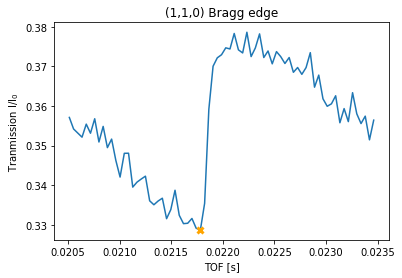

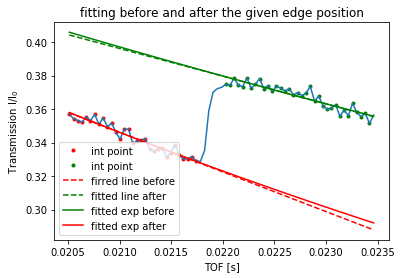

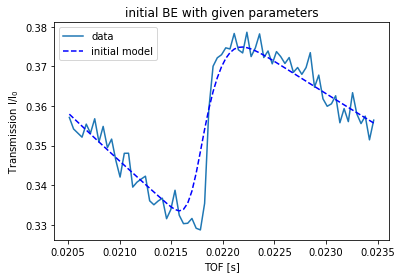

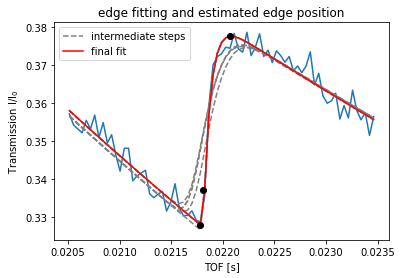

-----------Results of fitting: Edge Position------------
0.021809768683772338
[0.02180977 0.         0.         0.         0.         0.        ]
[0.0245 0.0275]
[256 330]
287
[0.0245 0.0275]
0.0257555
-----------Fitting calibration Bragg Edge--------------
[[Model]]
    Model(BraggEdgeExponential)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 12
    # data points      = 74
    # variables        = 7
    chi-square         = 2.9357e-04
    reduced chi-square = 4.3816e-06
    Akaike info crit   = -906.372642
    Bayesian info crit = -890.244187
[[Variables]]
    t0:     0.02578407 +/- 9.9178e-06 (0.04%) (init = 0.0257992)
    alpha:  1.6007e-04 +/- 1.9546e-05 (12.21%) (init = 0.0001057723)
    sigma:  7.5896e-06 +/- 3.8317e-05 (504.86%) (init = 1.897285e-05)
    a1:    -0.39495464 +/- 0.10519148 (26.63%) (init = -0.03334772)
    a2:     53.7830495 +/- 3.90013922 (7.25%) (init = 40.41624)
    a5:    -0.09765389 +/- 0.12886542 (131.96%) (init = -0.5215

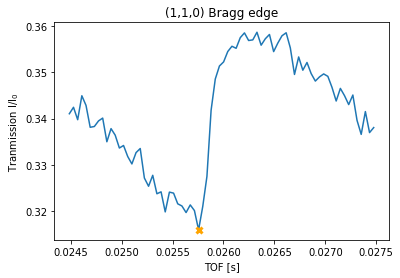

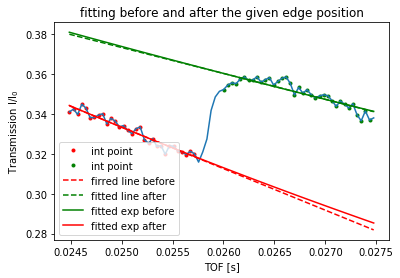

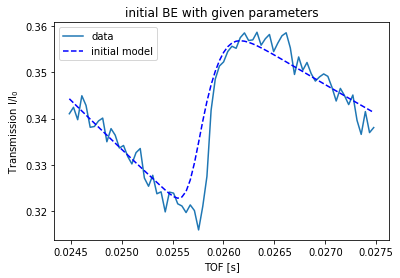

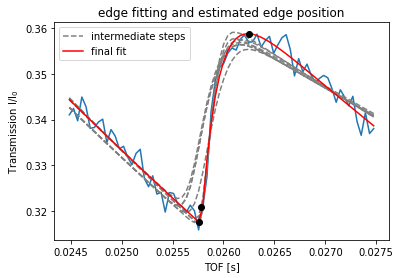

-----------Results of fitting: Edge Position------------
0.025784068408048897
[0.02180977 0.02578407 0.         0.         0.         0.        ]
[0.0275 0.031 ]
[330 415]
362
[0.0275 0.031 ]
0.0288275
-----------Fitting calibration Bragg Edge--------------
[[Model]]
    Model(BraggEdgeExponential)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 135
    # data points      = 85
    # variables        = 7
    chi-square         = 2.0390e-04
    reduced chi-square = 2.6141e-06
    Akaike info crit   = -1085.94500
    Bayesian info crit = -1068.84644
[[Variables]]
    t0:     0.02884696 +/- 0.14081693 (488.15%) (init = 0.02885288)
    alpha:  1.6055e-04 +/- 1.7163e-05 (10.69%) (init = 0.0001366004)
    sigma:  3.5121e-06 +/- 6.42380955 (182904134.21%) (init = 3.820674e-07)
    a1:    -0.45266151 +/- 0.05833410 (12.89%) (init = -0.3645194)
    a2:     52.4318408 +/- 1.93027488 (3.68%) (init = 49.54902)
    a5:    -0.10197766 +/- 0.08762697 (85.93%) (init =

/home/carminati_c/git/scripts/python/ToF_notebooks/AdvancedBraggEdgeFitting_v2.py:45: RuntimeWarning: invalid value encountered in multiply
  return (0.5*(term3(t,t0,sigma) - term4(t,t0,alpha,sigma)* term5(t,t0,alpha,sigma)))


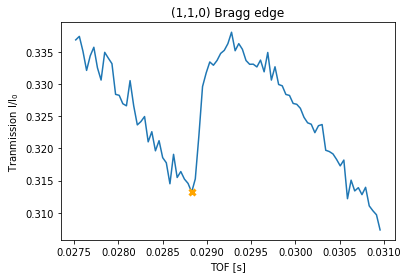

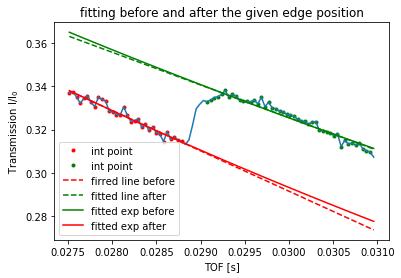

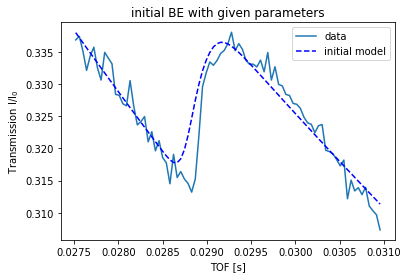

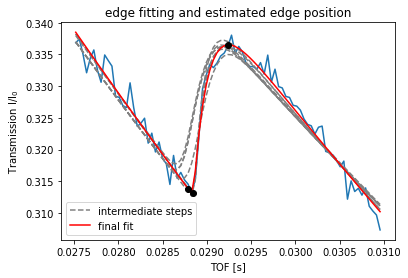

-----------Results of fitting: Edge Position------------
0.028846958780250537
[0.02180977 0.02578407 0.02884696 0.         0.         0.        ]
[0.031 0.036]
[415 555]
468
[0.031 0.036]
0.0331693
-----------Fitting calibration Bragg Edge--------------
[[Model]]
    Model(BraggEdgeExponential)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 33
    # data points      = 140
    # variables        = 7
    chi-square         = 6.9740e-04
    reduced chi-square = 5.2436e-06
    Akaike info crit   = -1695.37113
    Bayesian info crit = -1674.77963
[[Variables]]
    t0:     0.03331048 +/- 5.3201e-06 (0.02%) (init = 0.03332797)
    alpha:  2.5245e-04 +/- 1.0924e-05 (4.33%) (init = 0.0001673805)
    sigma:  1.4609e-05 +/- 1.2451e-05 (85.23%) (init = 2.442396e-05)
    a1:     0.07121159 +/- 0.06442025 (90.46%) (init = 0.7280315)
    a2:     26.4360163 +/- 1.82281321 (6.90%) (init = 7.906674)
    a5:    -0.68481350 +/- 0.08292930 (12.11%) (init = -1.489619)
   

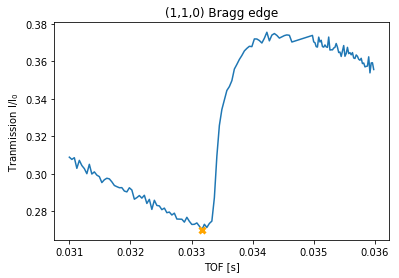

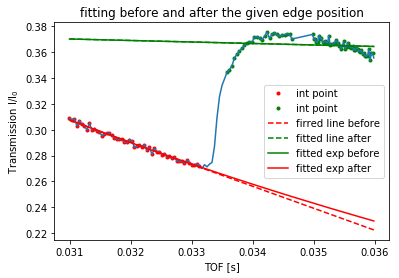

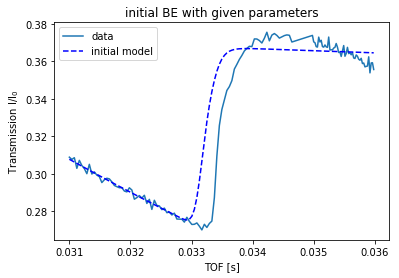

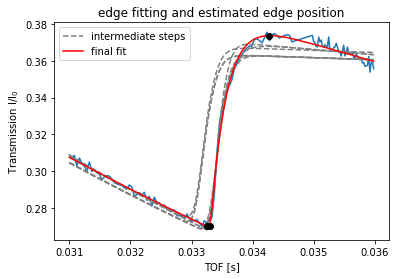

-----------Results of fitting: Edge Position------------
0.033310479474766126
[0.02180977 0.02578407 0.02884696 0.03331048 0.         0.        ]
[0.038 0.05 ]
[ 652 1222]
789
[0.038 0.05 ]
0.0407971
-----------Fitting calibration Bragg Edge--------------
[[Model]]
    Model(BraggEdgeExponential)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 17
    # data points      = 570
    # variables        = 7
    chi-square         = 0.00224011
    reduced chi-square = 3.9789e-06
    Akaike info crit   = -7080.71353
    Bayesian info crit = -7050.29407
[[Variables]]
    t0:     0.04079696 +/- 6.1090e-06 (0.01%) (init = 0.04079885)
    alpha:  3.6745e-04 +/- 9.7138e-06 (2.64%) (init = 0.0003563697)
    sigma:  1.1307e-07 +/- 2.9861e-05 (26409.06%) (init = 2.542771e-07)
    a1:    -0.66962394 +/- 0.00763408 (1.14%) (init = -0.6664056)
    a2:     42.2424114 +/- 0.16696315 (0.40%) (init = 42.20076)
    a5:    -0.12419611 +/- 0.02823700 (22.74%) (init = -0.125420

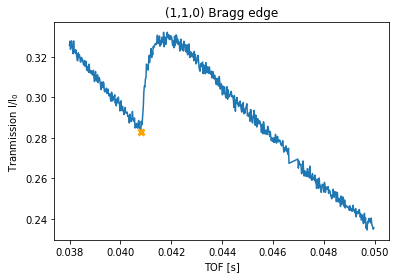

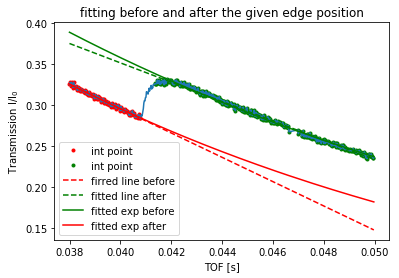

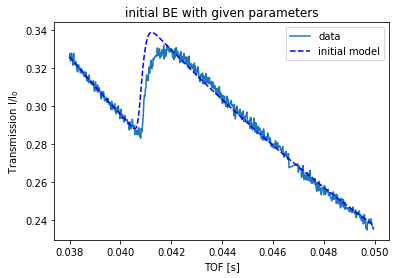

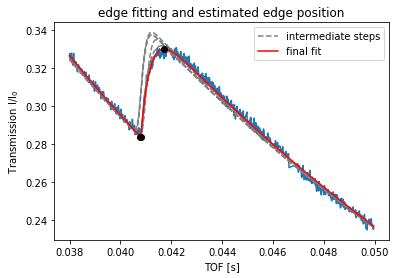

-----------Results of fitting: Edge Position------------
0.040796962890143215
[0.02180977 0.02578407 0.02884696 0.03331048 0.04079696 0.        ]
[0.05 0.08]
[1222 2329]
1543
[0.05 0.08]
0.056568
-----------Fitting calibration Bragg Edge--------------
[[Model]]
    Model(BraggEdgeExponential)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 22
    # data points      = 1107
    # variables        = 7
    chi-square         = 0.03410837
    reduced chi-square = 3.1008e-05
    Akaike info crit   = -11485.0970
    Bayesian info crit = -11450.0311
[[Variables]]
    t0:     0.05792114 +/- 2.2644e-05 (0.04%) (init = 0.05792649)
    alpha:  2.0698e-04 +/- 1.3263e-05 (6.41%) (init = 0.0002011545)
    sigma:  2.1230e-04 +/- 1.4998e-05 (7.06%) (init = 0.0002202973)
    a1:     0.14316311 +/- 0.00461929 (3.23%) (init = 0.1538233)
    a2:     7.75975988 +/- 0.06852589 (0.88%) (init = 7.61007)
    a5:    -0.04903766 +/- 0.03537869 (72.15%) (init = -0.1963016)
    a6

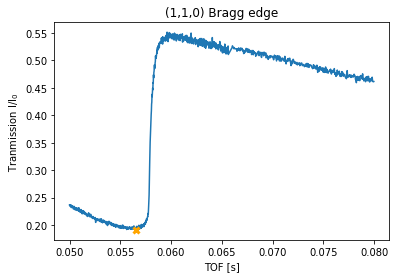

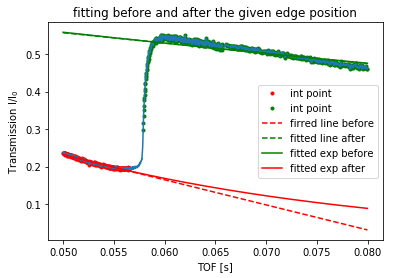

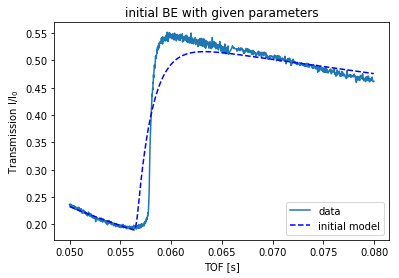

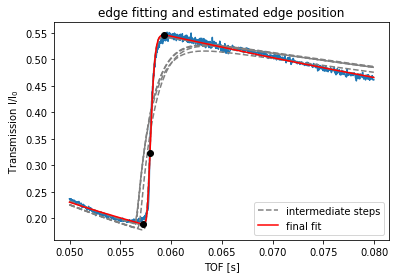

-----------Results of fitting: Edge Position------------
0.057921135641733644
[0.02180977 0.02578407 0.02884696 0.03331048 0.04079696 0.05792114]
computed moderator decay:
[1.32101961e-06 7.58956475e-06 3.51211829e-06 1.46086390e-05
 1.13069402e-07 2.12295833e-04]
[1.532 1.812 2.026 2.34  2.866 4.054]
[0.02180977 0.02578407 0.02884696 0.03331048 0.04079696 0.05792114]


In [19]:

print(peaks) # here I see which are the positions of the peaks in the cal spectrum
print(peaks_th) # position of the peaks in the theoretical spectrum

# Here I have to loop over the found peaks and fit with the AdvancedBraggEdgeFiltering, I take the 6 peaks found in the cal spectrum and define some range

# first I remove the more peaks that I have in the theoretical spectrum
peaks_ref= peaks_th[-6:]
print(peaks_ref)

# unitless numbers, this is NOT physically meaningfull
# est_sigma= +0.5
# est_alpha= np.array([0.5,0.5,0.5,0.5,0.5,1.5])

#in TOF [s!]
est_sigma = 0.0001
est_alpha = np.array([0.0001,0.0001,0.0001,0.0001,0.0001,0.0015]) # This takes into account that the alpha values as a pseudo-sigmoid behaviour
CalPoints = np.zeros(6)
RefPoints = np.zeros(6)

RefPoints[0]=dhkl_alphaFe[6]*2

for i in range(1, 6):
    RefPoints[i]=dhkl_alphaFe[5-i]*2
#     RefPoints[i,0]=l2tof(RefPoints[i,1])

print('--- RefPoints obtained from lattice parameters ---')
print(RefPoints)
print('number of peaks: ',len(peaks))

computed_alpha = np.zeros(len(peaks))

for i in range(0, len(peaks)):
# for i in range(len(peaks)-6, len(peaks)-5):
    
    print(tof_ranges[i,:])
    myrange = np.array([find_nearest(mycaltof, tof_ranges[i,0]), find_nearest(mycaltof,tof_ranges[i,1])])
    print(myrange)
    print(peaks[i])
    print(tof_ranges[i,:])
    print(mycaltof[peaks[i]])
            

    print('-----------Fitting calibration Bragg Edge--------------')
#     results_cal = AdvancedBraggEdgeFitting.AdvancedBraggEdgeFitting(cal_spectrum_norm, myrange, peaks[i+2], est_sigma, est_alpha, False, False)
#     results_cal = AdvancedBraggEdgeFitting_v2.AdvancedBraggEdgeFitting(cal_spectrum_norm, myrange, peaks[i+2], est_sigma, est_alpha[i], False, False, True)
    results_cal = AdvancedBraggEdgeFitting_v2.AdvancedBraggEdgeFitting(cal_spectrum_norm, myrange, mycaltof, peaks[i], est_sigma, est_alpha[i], False, False, False)
    print('-----------Results of fitting: Edge Position------------')
    print(results_cal['t0'])

#     CalPoints[i] = mycaltof[myrange[0]+int(results_cal['t0'])]
    CalPoints[i] = results_cal['t0']
    computed_alpha[i] = results_cal['sigma']

    print(CalPoints)
#     print(RefPoints)

print('computed moderator decay:')
print(computed_alpha)
print(RefPoints)
print(CalPoints)

## I will then fit the calculated TOF to the theoretical lambda, x= RefPoints (theoretical lambda) y=mycaltof (computed TOF) 

[1.532 1.812 2.026 2.34  2.866 4.054]
[0.02180977 0.02578407 0.02884696 0.03331048 0.04079696 0.05792114]
[6.98447034e+01 1.15864010e-02]


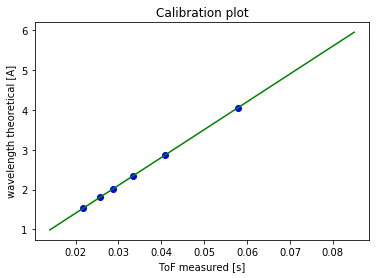

In [20]:
#Calibration on the lattice parameters value
print(RefPoints) # theoretical lambda
print(CalPoints) # calculated TOF

z= np.polyfit( CalPoints,RefPoints,1)
print(z)


plt.plot(CalPoints,RefPoints,'ob')
# plt.plot( mytof, mylambda,'-r')
plt.plot( mycaltof, mycaltof*z[0]+z[1],'-g')
# # plt.xlim(1,5)
plt.ylabel('wavelength theoretical [A]')
plt.xlabel('ToF measured [s]')
# # plt.ylim(0.0,0.03)
# plt.legend(['calibration points','theoretical curve', 'fit'])
plt.title('Calibration plot')
plt.savefig('calibratio_plot.pdf')

In [21]:
# This is instead to compute l0 and L
lambda0 = z[1]
L = (h/(m*z[0]))/1e-10
print(lambda0,L)

0.011586401025970494 56.64042963462982


(2451,)


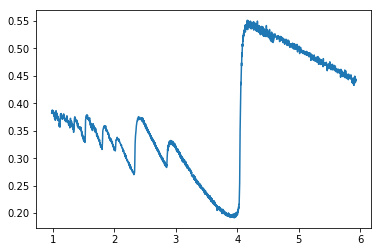

In [22]:
cal_lambda=tof2l(mycaltof)
print(np.shape(cal_lambda))
plt.figure()
plt.plot(cal_lambda, cal_spectrum_norm)

np.savetxt('mycal_lambda.txt', cal_lambda)

### My final result for IMAT flight-path calibration:
#### L = 56.36 m
#### lambda0 = 0.00189 (computed with linear functions before and after the BE)
#### lambda0 = 0.0023 (computed with exponential functions)



## Plotting of the moderator decay 

Text(0, 0.5, 'alpha [microsec]')

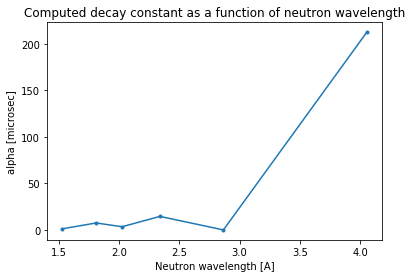

In [23]:
plt.figure()
plt.plot(RefPoints, computed_alpha*1e+6,'.-')
plt.title('Computed decay constant as a function of neutron wavelength')
plt.xlabel('Neutron wavelength [A]')
plt.ylabel('alpha [microsec]')

## Reported moderator decay from the IMAT paper 2019

In [24]:
def IMAT_moderatordecay(l):
    return (418/(1+155.1*np.exp(-2.46*l)))

Text(0.5, 1.0, 'given IMAT moderator decay as a function of neutron wavelength')

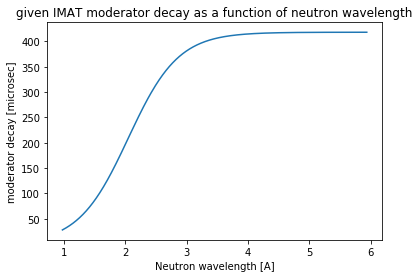

In [25]:
th_alpha = np.zeros(len(cal_lambda))

for i in range(0,len(cal_lambda)):
    th_alpha[i] = IMAT_moderatordecay(cal_lambda[i])
    
plt.figure()
plt.plot(cal_lambda, th_alpha)
plt.xlabel('Neutron wavelength [A]')
plt.ylabel('moderator decay [microsec]')
plt.title('given IMAT moderator decay as a function of neutron wavelength')

## Some tests here to get the peak height 

In [26]:
# I take the restuls on the last fit
t0=results_cal['t0']
sigma = results_cal['sigma']
alpha = results_cal['alpha']
a1 = results_cal['a1']
a2 = results_cal['a2']
a5 = results_cal['a5']
a6 = results_cal['a6']
results = results_cal['final_result']



0.057921135641733644
(1107,)
(1107,)
(1107,)
[1222 2329]


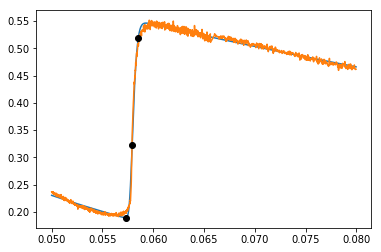

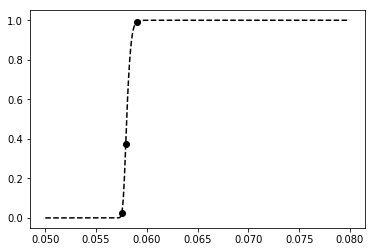

In [27]:
fit = results.best_fit
myt = mycaltof[1222:2329]
print(t0)
print(np.shape(myt))
print(np.shape(results.data))
print(np.shape(fit))
print(myrange)
plt.plot(myt, fit)
plt.plot(myt, results.data)
plt.plot(t0,fit[find_nearest(t0,myt)],'ok')
plt.plot(t0+3*alpha,fit[find_nearest(t0+3*alpha,myt)],'ok')
plt.plot(t0-3*alpha,fit[find_nearest(t0-3*alpha,myt)],'ok')

step_function = AdvancedBraggEdgeFitting_v2.B(myt,t0,alpha,sigma)
max_pos = find_first(step_function,0.99)
min_pos = find_last(step_function,0.0)

plt.figure()
plt.plot(myt,step_function,'k--')
# plt.figure()
plt.plot(t0,step_function[find_nearest(t0,myt)],'ok')
plt.plot(myt[max_pos], step_function[max_pos],'ok')
plt.plot(myt[min_pos], step_function[min_pos],'ok')


# plt.plot(t0+3*alpha,step_function[find_nearest(t0+3*alpha,myt)],'ok')
# plt.plot(t0-3*alpha,step_function[find_nearest(t0-3*alpha,myt)],'ok')
# plt.plot(myt, AdvancedBraggEdgeFitting_v2.exp_after(myt,a1,a2))
# plt.plot(myt, AdvancedBraggEdgeFitting_v2.exp_combined(myt,a1,a2,a5,a6))
# plt.plot((t0),fit[int(t0)],'ok')
# plt.plot(int(t0+3*sigma), fit[int(t0+3*sigma)], 'ok')
# plt.plot(int(t0-3*sigma), fit[int(t0-3*sigma)], 'ok')

# print(fit[int(t0)])
# print(fit[int(t0+3*sigma)])
# print(fit[int(t0-3*sigma)])
# print('peak height: ', np.abs(fit[int(t0-3*sigma)]-fit[int(t0+3*sigma)])) # i must say that it works but not for all cases 

In [28]:
print(step_function)

[1.80706395e-305 6.63771300e-304 2.41555402e-302 ... 1.00000000e+000
 1.00000000e+000 1.00000000e+000]


0.057921135641733644
0.2300866632624263
0.2300866632624263
0.2300866632624263
peak height:  0.0


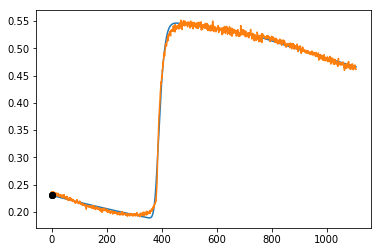

In [29]:
fit = results.best_fit
print(t0)
plt.plot(fit)
plt.plot(results.data)
plt.plot(int(t0),fit[int(t0)],'ok')
plt.plot(int(t0+3*sigma), fit[int(t0+3*sigma)], 'ok')
plt.plot(int(t0-3*sigma), fit[int(t0-3*sigma)], 'ok')

print(fit[int(t0)])
print(fit[int(t0+3*sigma)])
print(fit[int(t0-3*sigma)])
print('peak height: ', np.abs(fit[int(t0-3*sigma)]-fit[int(t0+3*sigma)])) 

## Here I fit everything again in lambda, to check the the lattice parameter is correct 

In [30]:

print(peaks) # here I see which are the positions of the peaks in the cal spectrum
print(peaks_th) # position of the peaks in the theoretical spectrum

# Here I have to loop over the found peaks and fit with the AdvancedBraggEdgeFiltering, I take the 6 peaks found in the cal spectrum and define some range

# first I remove the more peaks that I have in the theoretical spectrum
peaks_ref= peaks_th[-6:]
print(peaks_ref)

# unitless numbers, this is NOT physically meaningfull
# est_sigma= +0.5
# est_alpha= np.array([0.5,0.5,0.5,0.5,0.5,1.5])

#in TOF [s!]
est_sigma = 0.0001
est_alpha = np.array([0.0001,0.0001,0.0001,0.0001,0.0001,0.0015]) # This takes into account that the alpha values as a pseudo-sigmoid behaviour
CalPoints = np.zeros(6)
RefPoints = np.zeros(6)

RefPoints[0]=dhkl_alphaFe[6]*2

for i in range(1, 6):
    RefPoints[i]=dhkl_alphaFe[5-i]*2
#     RefPoints[i,0]=l2tof(RefPoints[i,1])

print('--- RefPoints obtained from lattice parameters ---')
print(RefPoints)
print('number of peaks: ',len(peaks))

computed_alpha = np.zeros(len(peaks)-2)

for i in range(0, len(peaks)-2):
# for i in range(0, 1):
    
#     print(tof_ranges[i,:])
    print(lambda_ranges[i,:])
#     myrange = np.array([find_nearest(mycaltof, tof_ranges[i,0]), find_nearest(mycaltof,tof_ranges[i,1])])
    myrange = np.array([find_nearest(cal_lambda, lambda_ranges[i,0]), find_nearest(cal_lambda,lambda_ranges[i,1])])
    print(myrange)
    print(peaks[i+2])
    print(tof_ranges[i,:])
    print(cal_lambda[peaks[i+2]])
            

    print('-----------Fitting calibration Bragg Edge--------------')
#     results_cal = AdvancedBraggEdgeFitting.AdvancedBraggEdgeFitting(cal_spectrum_norm, myrange, peaks[i+2], est_sigma, est_alpha, False, False)
#     results_cal = AdvancedBraggEdgeFitting_v2.AdvancedBraggEdgeFitting(cal_spectrum_norm, myrange, peaks[i+2], est_sigma, est_alpha[i], False, False, True)
    results_cal = AdvancedBraggEdgeFitting_v2.AdvancedBraggEdgeFitting(cal_spectrum_norm, myrange, cal_lambda, RefPoints[i], est_sigma, est_alpha[i], False, False, True)
    print('-----------Results of fitting: Edge Position------------')
    print(results_cal['t0'])

#     CalPoints[i] = mycaltof[myrange[0]+int(results_cal['t0'])]
    CalPoints[i] = results_cal['t0']
    computed_alpha[i] = results_cal['sigma']

    print(CalPoints)
#     print(RefPoints)

print('computed moderator decay:')
print(computed_alpha)

[ 190  287  362  468  789 1543]
[  9  33  50  57  67  75  87 107 151]
[ 57  67  75  87 107 151]
--- RefPoints obtained from lattice parameters ---
[1.532 1.812 2.026 2.34  2.866 4.054]
number of peaks:  6
[1.45 1.6 ]
[165 217]
362
[0.0205 0.0235]
2.013448188273184
-----------Fitting calibration Bragg Edge--------------


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices